In [2]:
# Importing necessary libraries
import numpy as np
import os
import re
import sys
import glob
from textwrap import wrap
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Reshape, concatenate, Embedding, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Setting up the paths for images and captions dataset
img_path = "/home/devcontainers/Datasets/Images"
caption_path = "/home/devcontainers/Datasets/captions.txt"
caption = pd.read_csv(caption_path)

# def clean_imagefile(filename):
#     filename = filename.split('#')[0]
#     match = re.match(r'(.*\.jpg)', filename)
#     if match:
#         return match.group(1)
#     if not filename.endswith('.jpg'):
#         filename += '.jpg'
#     return filename
    
# caption['image_clean'] = caption['image'].apply(clean_imagefile)
caption.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


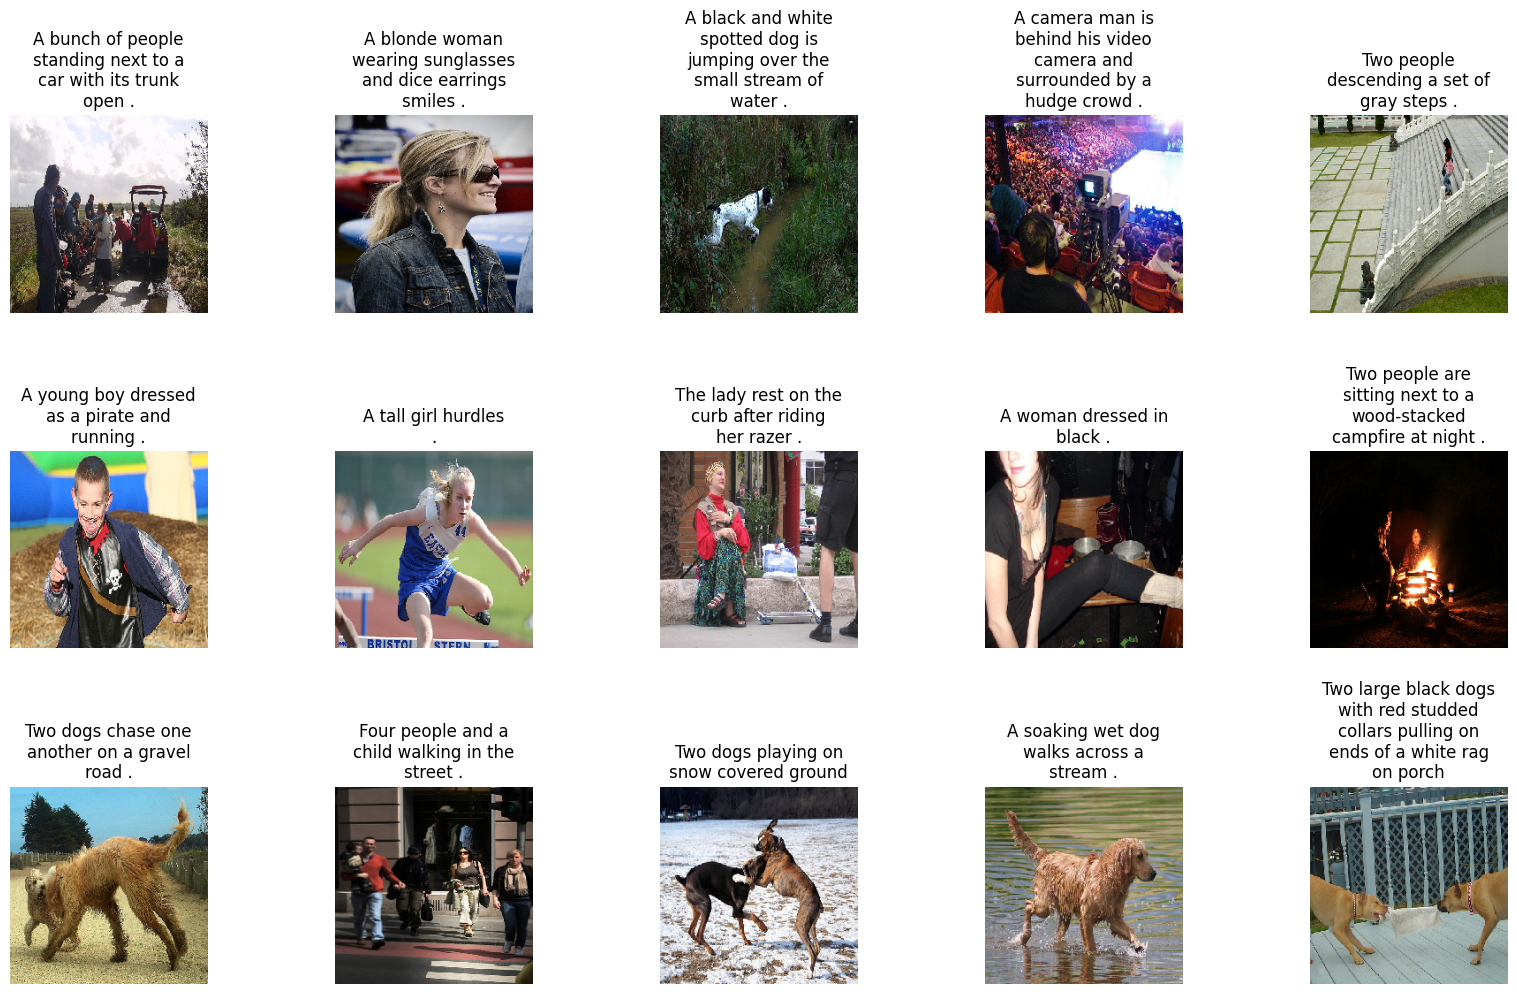

In [13]:
# Functions to read, preprocess and display images
def read_image(image_path):
    img = load_img(image_path, color_mode='rgb', target_size=(224, 224))
    img = img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    # img = preprocess_input(img)
    img /= 255.0
    return img

def display_image(image_df):
    image_df = image_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    i=0
    for i in range(len(image_df)):
        plt.subplot(5,5,i+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        img = read_image(os.path.join(img_path, image_df.image[i]))
        plt.imshow(img)
        plt.title("\n".join(wrap(image_df.caption[i], 20)))
        plt.axis('off')

display_image(caption.sample(15))

In [14]:
# Function to preprocess texts to reduce redundancy with start and end tokens
def preprocess_texts(caption_df):
    caption_df['caption'] = caption_df['caption'].apply(lambda x: x.lower())
    caption_df['caption'] = caption_df['caption'].apply(lambda x: re.sub("[^A-Za-z]"," ",x))
    caption_df['caption'] = caption_df['caption'].apply(lambda x: re.sub("\s+", " ",x))
    caption_df['caption'] = caption_df['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    caption_df['caption'] = caption_df['caption'].apply(lambda x: f"startseq {x} endseq")
    return caption_df

caption = preprocess_texts(caption)
captions = caption['caption'].tolist()
caption.head()

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...


In [15]:
# Tokenizing the captions to create list of indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = 1+len(tokenizer.word_index)
maxLen = max([len(c.split()) for c in captions])
print(f"Vocabulary Size: {vocab_size}, Max Length of Caption: {maxLen}")

images = caption['image'].unique().tolist()
num_images = len(images)
print(f"Number of unique Images: {num_images}")

split_idx = round(num_images * 0.9)
train_images = images[:split_idx]
test_images = images[split_idx:]
print(f"Number of Training Images: {len(train_images)}, Number of Testing Images: {len(test_images)}")

train = caption[caption['image'].isin(train_images)]
train.reset_index(inplace=True, drop=True)
test = caption[caption['image'].isin(test_images)]
test.reset_index(inplace=True, drop=True)

Vocabulary Size: 8427, Max Length of Caption: 35
Number of unique Images: 8091
Number of Training Images: 7282, Number of Testing Images: 809


In [ ]:
# Getting the features or encodings for a given image using DenseNet201
img_model = DenseNet201()
model = Model(inputs=img_model.input, outputs=img_model.layers[-2].output)
features = {}
for image in caption['image'].unique().tolist():
    img_file = os.path.join(img_path, image)
    if not os.path.exists(img_file):
        print(f"Missing: {img_file}")
        continue
    img = read_image(img_file)
    img = np.expand_dims(img, axis=0)
    feature = model.predict(img)
    features[image] = feature

In [17]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, caption_df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, maxLen, features, shuffle=True):
        self.caption_df = caption_df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.directory = directory
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.maxLen = maxLen
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.caption_df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.caption_df = self.caption_df.sample(frac=1).reset_index(drop=True)
            
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch_df = self.caption_df.iloc[index*self.batch_size:(index+1)*self.batch_size,:]
        X1, X2, y = self.__getdata(batch_df)
        return (X1, X2), y
    
    def __getdata(self, batch_df):
        X1, X2, y = [], [], []
        images = batch_df[self.X_col].tolist()
        for image in images:
            feature = self.features[image][0]
            captions = batch_df[batch_df[self.X_col] == image][self.y_col].tolist()
            for c in captions:
                seq = self.tokenizer.texts_to_sequences([c])[0]
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.maxLen)[0]
                    out_seq = to_categorical(out_seq, num_classes=self.vocab_size)
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        
        return X1, X2, y

In [18]:
# Mapping the words to glove vector representations
embeddings_idx = {}
with open('/home/devcontainers/Datasets/glove.6B.300d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_idx[word] = coefs
        
print(f"Found {len(embeddings_idx)} word vectors.")

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxLen, trainable=True)

Found 400000 word vectors.


In [19]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(maxLen,))
fe1 = Dense(300, activation='relu')(input1)
fe1_reshaped = Reshape((1, 300), input_shape=(300,))(fe1)
se1 = embedding_layer(input2)
merged = concatenate([fe1_reshaped, se1], axis=1)
se2 = LSTM(300)(merged)
x = Dropout(0.5)(se2)
x = add([x, fe1])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [20]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300)       │    576,300 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 300)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 300)   │  2,528,100 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36, 300)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 300)       │    721,200 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 300)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     38,528 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8427)      │  1,087,083 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,951,211 (18.89 MB)

 Trainable params: 4,951,211 (18.89 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
train_generator = DataGenerator(caption_df=train,X_col='image',y_col='caption',batch_size=32,directory=img_path, tokenizer=tokenizer,vocab_size=vocab_size,maxLen=maxLen,features=features)
validation_generator = DataGenerator(caption_df=test,X_col='image',y_col='caption',batch_size=32,directory=img_path, tokenizer=tokenizer,vocab_size=vocab_size,maxLen=maxLen,features=features)

model_checkpoint = ModelCheckpoint('caption_model2.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history = caption_model.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[model_checkpoint, reduce_lr, early_stopping], verbose=1)

Epoch 1/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1762 - loss: 5.2858
Epoch 1: val_loss improved from inf to 4.03581, saving model to caption_model2.h5


1137/1137 ━━━━━━━━━━━━━━━━━━━━ 164s 141ms/step - accuracy: 0.1762 - loss: 5.2853 - val_accuracy: 0.2698 - val_loss: 4.0358 - learning_rate: 0.0010
Epoch 2/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2656 - loss: 4.1114
Epoch 2: val_loss improved from 4.03581 to 3.76733, saving model to caption_model2.h5


1137/1137 ━━━━━━━━━━━━━━━━━━━━ 144s 126ms/step - accuracy: 0.2656 - loss: 4.1114 - val_accuracy: 0.2967 - val_loss: 3.7673 - learning_rate: 0.0010
Epoch 3/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2864 - loss: 3.8444
Epoch 3: val_loss improved from 3.76733 to 3.66023, saving model to caption_model2.h5


1137/1137 ━━━━━━━━━━━━━━━━━━━━ 107s 93ms/step - accuracy: 0.2864 - loss: 3.8444 - val_accuracy: 0.3075 - val_loss: 3.6602 - learning_rate: 0.0010
Epoch 4/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2977 - loss: 3.6855
Epoch 4: val_loss improved from 3.66023 to 3.60169, saving model to caption_model2.h5


1137/1137 ━━━━━━━━━━━━━━━━━━━━ 104s 91ms/step - accuracy: 0.2977 - loss: 3.6855 - val_accuracy: 0.3140 - val_loss: 3.6017 - learning_rate: 0.0010
Epoch 5/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3065 - loss: 3.5618
Epoch 5: val_loss improved from 3.60169 to 3.56655, saving model to caption_model2.h5


1137/1137 ━━━━━━━━━━━━━━━━━━━━ 102s 89ms/step - accuracy: 0.3065 - loss: 3.5618 - val_accuracy: 0.3197 - val_loss: 3.5665 - learning_rate: 0.0010
Epoch 6/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3128 - loss: 3.4731
Epoch 6: val_loss improved from 3.56655 to 3.55115, saving model to caption_model2.h5


1137/1137 ━━━━━━━━━━━━━━━━━━━━ 97s 85ms/step - accuracy: 0.3128 - loss: 3.4731 - val_accuracy: 0.3244 - val_loss: 3.5512 - learning_rate: 0.0010
Epoch 7/20
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3190 - loss: 3.3905
Epoch 7: val_loss did not improve from 3.55115
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1112s 978ms/step - accuracy: 0.3190 - loss: 3.3905 - val_accuracy: 0.3262 - val_loss: 3.5671 - learning_rate: 0.0010
Epoch 8/20
1136/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3221 - loss: 3.3367
Epoch 8: val_loss did not improve from 3.55115
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 72s 63ms/step - accuracy: 0.3221 - loss: 3.3367 - val_accuracy: 0.3295 - val_loss: 3.5814 - learning_rate: 0.0010
Epoch 9/20
1136/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3249 - loss: 3.2847
Epoch 9: val_loss did not improve from 3.55115
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.3249 - loss: 3.2847 - val_accuracy: 0.3282 - val_loss: 3.6020 - learning_rate: 0.0010
Epoch 10

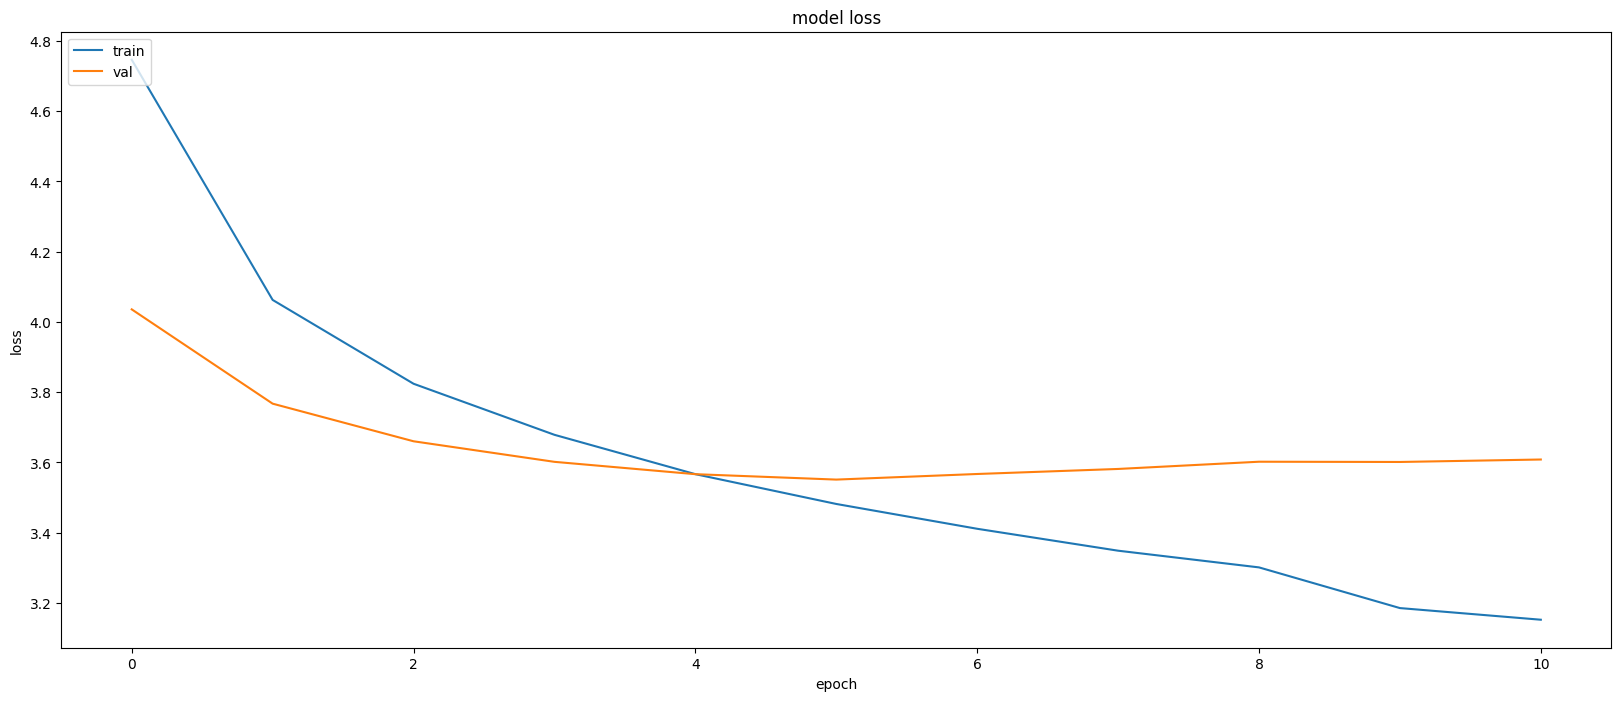

In [22]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

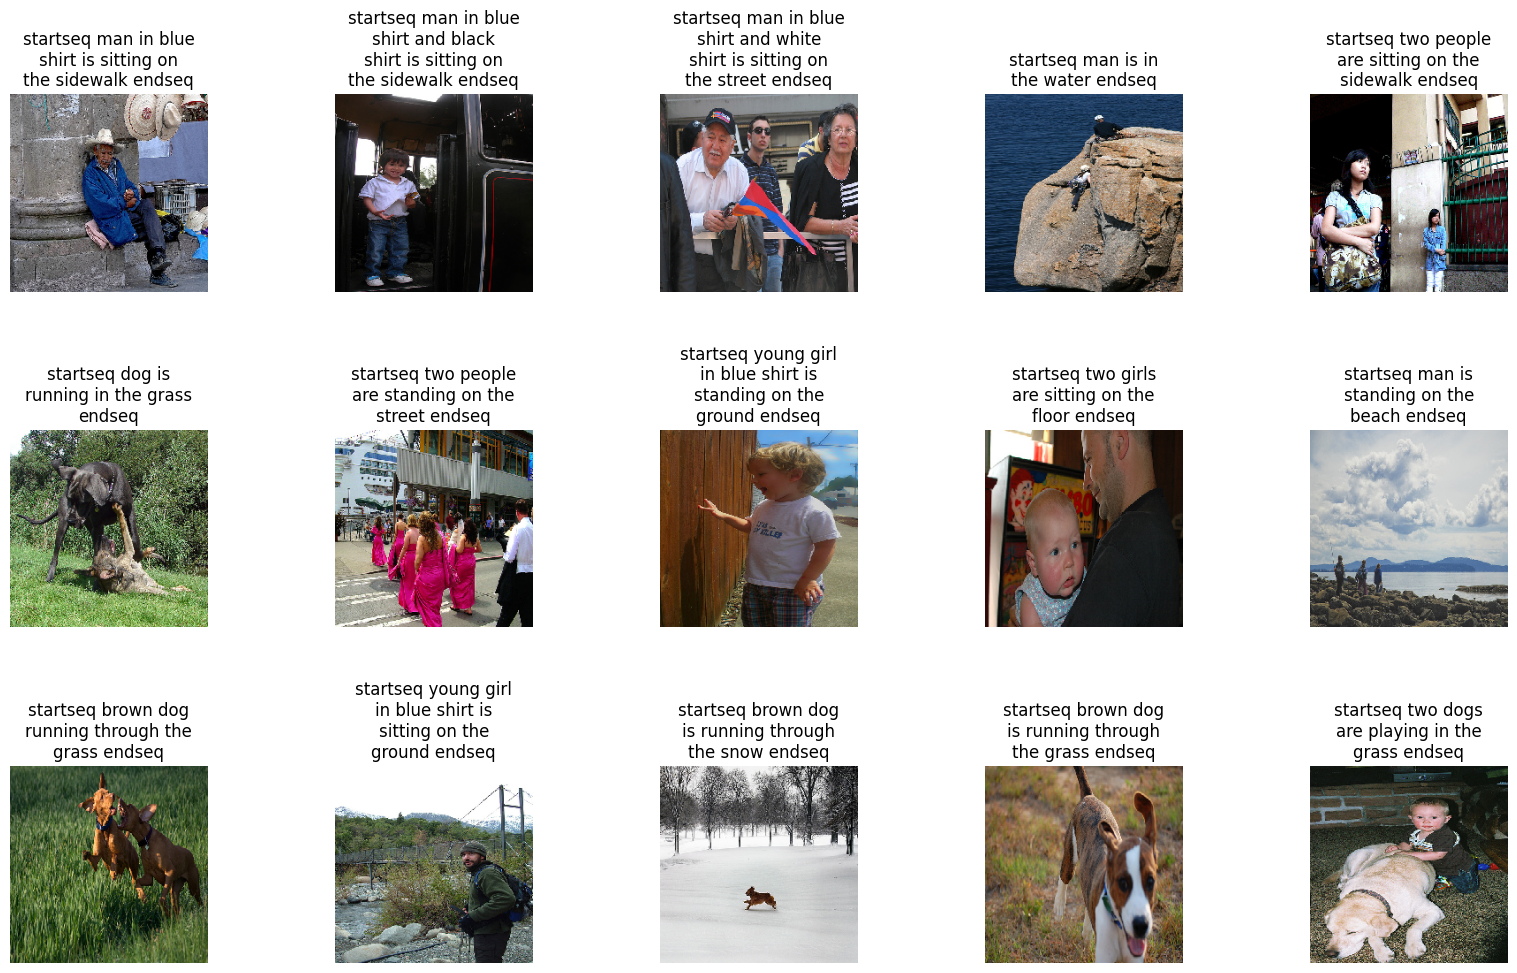

In [26]:
def idx_to_word(idx,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==idx:
            return word
    return None

def predict_caption(model, image, tokenizer, maxLen, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(maxLen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxLen)
        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
            
    return in_text 

samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

for idx,value in samples.iterrows():
    img = load_img(os.path.join(img_path, value['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    caption = predict_caption(caption_model, value['image'], tokenizer, maxLen, features)
    samples.loc[idx,'caption'] = caption
    
display_image(samples)

In [24]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)